# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.779434,False,-0.998534
1,-0.802786,True,5.268301
2,0.081912,True,4.684378
3,-0.663332,False,-1.575482
4,0.272922,True,5.933512
...,...,...,...
995,-0.808276,False,1.095346
996,1.000405,True,5.453317
997,0.993474,True,5.675957
998,-2.339430,False,-0.439721


<Axes: xlabel='v0'>

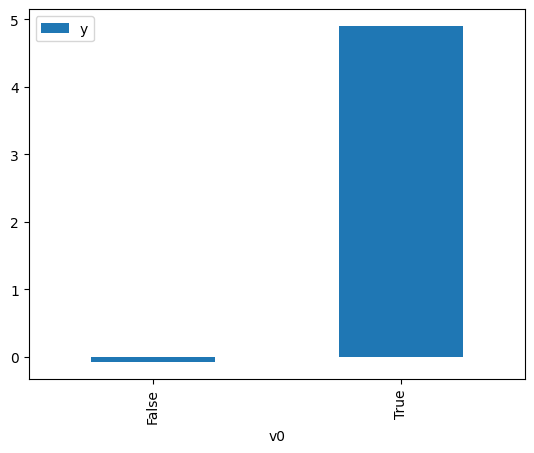

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

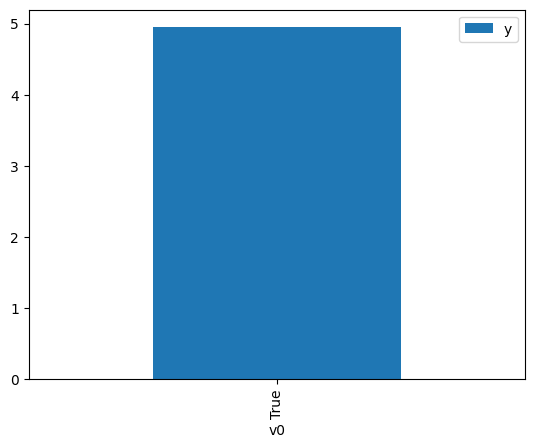

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.379947,False,-0.501847,0.937476,1.066694
1,-1.310688,False,-2.311240,0.928533,1.076968
2,0.198657,False,-1.196489,0.364072,2.746711
3,-1.089505,False,-0.169138,0.891567,1.121620
4,-1.247402,False,-0.173192,0.919344,1.087732
...,...,...,...,...,...
995,-0.807478,False,-1.841681,0.821049,1.217954
996,0.075530,False,0.220189,0.424813,2.353974
997,-0.767379,False,0.963948,0.808536,1.236803
998,-1.261147,False,2.066674,0.921427,1.085273


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.144495,True,3.756358,0.609616,1.640376
1,-1.094854,True,4.946011,0.107368,9.313774
2,-1.538996,True,5.327864,0.045798,21.834899
3,-0.830212,True,5.271277,0.172145,5.809042
4,-0.577762,True,4.513198,0.259551,3.852801
...,...,...,...,...,...
995,-0.478439,True,6.108350,0.300935,3.322979
996,-0.616844,True,5.587583,0.244319,4.093002
997,1.314215,True,6.297822,0.946103,1.056967
998,-0.434979,True,4.922905,0.320178,3.123260


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              4831.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):                        0.00
Time:                        17:28:27   Log-Likelihood:                         -1414.3
No. Observations:                1000   AIC:                                      2833.
Df Residuals:                     998   BIC:                                      2842.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1462      0.030      4.899      0.000       0.088       0.205
x2             5.0222      0.052     96.532      0.000       4.920       5.124
==============================================================================
Omnibus:                        1.162   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.559   Jarque-Bera (JB):                1.067
Skew:                           0.076   Prob(JB):                        0.586
Kurtosis:                       3.051   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""